<a href="https://colab.research.google.com/github/binesh-b0/Data_Science/blob/main/collaborativeFiltering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install surprise

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 11.8 MB 21.9 MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp37-cp37m-linux_x86_64.whl size=1633995 sha256=60f3fe2a6f6c91a1058fd81a3e175dd031652ec144a2c6d684d8f51014a7b0f9
  Stored in directory: /root/.cache/pip/wheels/76/44/74/b498c42be47b2406bd27994e16c5188e337c657025ab400c1c
Successfully built scikit-surprise


In [ ]:
!pip install tweet-preprocessor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


**Importing the required packages**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from collections import defaultdict

import surprise

from surprise.reader import Reader
from surprise import Dataset
from surprise.model_selection import GridSearchCV
from surprise.model_selection import cross_validate

##Matrix Factorization Algorithms
from surprise import SVD
from surprise import NMF

np.random.seed(42)

In [ ]:
import preprocessor as pp
import json
import requests

In [ ]:
from google.colab import drive
drive.mount('/content/drive/',force_remount=True)

Mounted at /content/drive/


**Reading movie ratings dataset**

In [ ]:
movies_df = pd.read_csv('/content/drive/My Drive/My data files/recommendation/u.data', sep='\t', index_col=False, names=['user id', 'movie id', 'rating', 'timestamp'])

In [ ]:
movies_df.head()

,user id,movie id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


**Reading the genre dataset**

In [ ]:
genre_df = pd.read_csv('/content/drive/My Drive/My data files/recommendation/u.item', sep='|', index_col=False, names=["movie id", "movie title", "release date", "video release date",
                                                                   "IMDb URL", "unknown", "Action", "Adventure", "Animation", "Children's",
                                                                   "Comedy", "Crime", "Documentary", "Drama", "Fantasy", "Film-Noir",
                                                                   "Horror", "Musical", "Mystery", "Romance", "Sci-Fi", "Thriller", "War", "Western"], encoding = "ISO-8859-1")
genre_df.head()

,movie id,movie title,release date,video release date,IMDb URL,unknown,Action,Adventure,Animation,Children's,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


**Getting only the movie id and the movie title from the genre dataset**

In [ ]:
genre_df = genre_df[['movie id', 'movie title']]

**Filtering the rating dataset based on two conditions,**

1.   Movie was rated atleast twice
2.   A user has rated atleast 5 movies

In [ ]:
min_ratings_movie = 2
min_ratings_user = 5

ratings_df = movies_df.groupby("movie id").filter(lambda x: x['movie id'].count() >= min_ratings_movie)
ratings_df = ratings_df.groupby("user id").filter(lambda x: x['user id'].count() >= min_ratings_user)

In [ ]:
ratings_df.head()

,user id,movie id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


**Loading the dataset using the Surprise Library and splitting it to training and test set.**

In [ ]:
reader = Reader(rating_scale=(0.5, 5))
data = Dataset.load_from_df(ratings_df[["user id",	"movie id", "rating"]], reader=reader)

train_set = data.build_full_trainset()

test_set = train_set.build_anti_testset()

**Computing the average of RMSE given by the five folds and append the empty list rmse_svd. Consequently, the list contains 100 measures of min RMSE given 100 consecutive values of k in each test set, and by five folds in every iteration.**

In [ ]:
def rmse_vs_factors(algorithm, data):
  rmse_alg = []

  for k in range(1, 101, 1):
    algo = algorithm(n_factors = k)
    loss_fce = cross_validate(algo, data, measures=['RMSE'], cv=5, verbose=False)["test_rmse"].mean()
    rmse_alg.append(loss_fce)

  return rmse_alg

In [ ]:
rmse_svd = rmse_vs_factors(SVD,data)

**The function returns a plot with two line subplots that display performance vs. numbers of factors.**

In [ ]:
def plot_rmse(rmse, algorithm):
  plt.figure(num=None, figsize=(11, 5), dpi=80, facecolor='w', edgecolor='k')

  plt.subplot(2,1,1)
  plt.plot(rmse)
  plt.xlim(0,100)
  plt.title("{0} Performance: RMSE Against Number of Factors".format(algorithm), size = 20 )
  plt.ylabel("Mean RMSE (cv=5)")

  plt.subplot(2,1,2)
  plt.plot(rmse)
  plt.xlim(0,50)
  plt.xticks(np.arange(0, 52, step=2))

  plt.xlabel("{0}(n_factor = k)".format(algorithm))
  plt.ylabel("Mean RMSE (cv=5)")
  plt.axvline(np.argmin(rmse), color = "r")

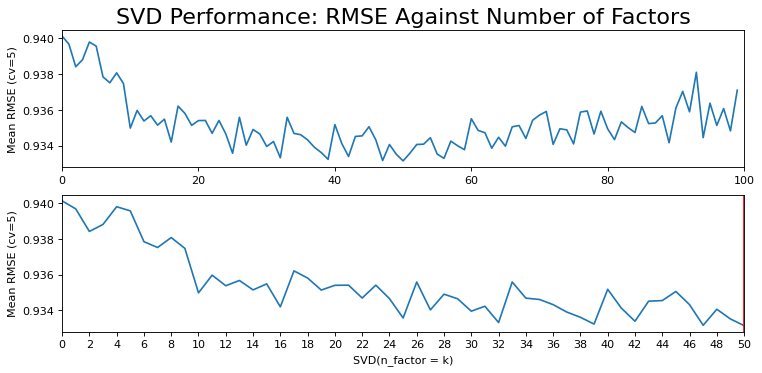

In [ ]:
plot_rmse(rmse_svd,"SVD")

**Finding the optimal value of n_factors using the GridSearchCV Algorithm.**

In [ ]:
param_grid = {'n_factors': [24,26,32,39,46,47,50]}
gs = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=5)
gs.fit(data)


# best RMSE score
print(gs.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

0.9344782473270847
{'n_factors': 26}


In [ ]:
algo_SVD = SVD(n_factors = 26)
algo_SVD.fit(train_set)


# Predict ratings for all pairs (i,j) that are NOT in the training set.
test_set = train_set.build_anti_testset()

predictions = algo_SVD.test(test_set)

# subset of the list  predictions
predictions[0:2]

[Prediction(uid=196, iid=302, r_ui=3.531599555373076, est=4.165367883462262, details={'was_impossible': False}),
 Prediction(uid=196, iid=377, r_ui=3.531599555373076, est=2.7325060295789956, details={'was_impossible': False})]

**Function to get the top N number of predictions for the given user.**

In [ ]:
def get_top_n(predictions, userId, movies_df, ratings_df, n = 10):

    #map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    #sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key = lambda x: x[1], reverse = True)
        top_n[uid] = user_ratings[: n ]


    #movies the user has already rated
    user_data = ratings_df[ratings_df['user id'] == (userId)]
    print('User {0} has already rated {1} movies.'.format(userId, user_data.shape[0]))


    #Data Frame with predictions.
    preds_df = pd.DataFrame([(id, pair[0],pair[1]) for id, row in top_n.items() for pair in row],
                        columns=["user id" ,"movie id","rat_pred"])


    #Return pred_usr, i.e. top N recommended movies with (merged) titles and genres.
    pred_usr = preds_df[preds_df["user id"] == (userId)].merge(movies_df, how = 'left', left_on = 'movie id', right_on = 'movie id')

    #Return hist_usr, i.e. top N historically rated movies with (merged) titles and genres for holistic evaluation
    hist_usr = ratings_df[ratings_df['user id'] == (userId) ].sort_values("rating", ascending = False).merge\
    (movies_df, how = 'left', left_on = 'movie id', right_on = 'movie id')


    return hist_usr, pred_usr

In [ ]:
hist_SVD, pred_SVD = get_top_n(predictions, movies_df = genre_df, userId = 1, ratings_df = ratings_df)

User 1 has already rated 272 movies.


In [ ]:
hist_SVD.head(15)

,user id,movie id,rating,timestamp,movie title
0,1,170,5,876892856,Cinema Paradiso (1988)
1,1,175,5,875072547,Brazil (1985)
2,1,119,5,876893098,Maya Lin: A Strong Clear Vision (1994)
3,1,181,5,874965739,Return of the Jedi (1983)
4,1,109,5,874965739,Mystery Science Theater 3000: The Movie (1996)
5,1,44,5,878543541,Dolores Claiborne (1994)
6,1,14,5,874965706,"Postino, Il (1994)"
7,1,12,5,878542960,"Usual Suspects, The (1995)"
8,1,223,5,876892918,Sling Blade (1996)
9,1,108,5,875240920,Kids in the Hall: Brain Candy (1996)


**Predicted Movies for the User Id 124**

In [ ]:
pred_SVD

,user id,movie id,rat_pred,movie title
0,1,408,4.817072,"Close Shave, A (1995)"
1,1,483,4.750533,Casablanca (1942)
2,1,357,4.564530,One Flew Over the Cuckoo's Nest (1975)
3,1,475,4.510357,Trainspotting (1996)
4,1,480,4.506053,North by Northwest (1959)
5,1,285,4.480923,Secrets & Lies (1996)
6,1,513,4.471863,"Third Man, The (1949)"
7,1,1039,4.463434,Hamlet (1996)
8,1,603,4.459882,Rear Window (1954)
9,1,611,4.457109,Laura (1944)
